### Expression 01

- Quantifying segmentations

In [4]:
%run ../utils.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from cytokit.cytometry import cytometer
from skimage import feature
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import exposure
from skimage import measure
from scipy import ndimage

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'reg001_X01_Y01.tif'

exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(None, None), slice(None, None)]
tile_file = 'reg001_X01_Y01.tif'

# exp_name = '20180426_D18_R1'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '20180426_D18_R1', 'views', 'v00-all', 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '20180426_D18_R1', 'views', 'v00-all', 'output', 'nopreproc', 'segm')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'reg001_X09_Y04.tif'

model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [5]:
exp_conf = cytokit_config.load(exp_conf_dir)

In [6]:
tile = cytokit_io.read_tile(osp.join(exp_data_dir, tile_file), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((8, 9, 4, 1008, 1344), dtype('uint16'))

In [7]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [8]:
exp_conf.channel_names[:10]

['HOECHST1',
 'CollagenIV',
 'CD7',
 'Ki67',
 'HOECHST2',
 'CD38',
 'CD31',
 'CD4',
 'HOECHST3',
 'CD45']

In [9]:
img_nuc = tile[nuc_cyc, :, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)
img_nuc.shape

(9, 1008, 1344)

In [10]:
import imp
imp.reload(cytometer)

<module 'cytokit.cytometry.cytometer' from '/lab/repos/cytokit/python/pipeline/cytokit/cytometry/cytometer.py'>

In [11]:
input_shape = img_nuc.shape[-2:] + (1,)
cytom = cytometer.Cytometer2D(input_shape, model_path).initialize()

In [12]:
%%time
img_seg, img_pred, img_bin = cytom.segment(img_nuc, proba_threshold=.7)

CPU times: user 12.2 s, sys: 2.28 s, total: 14.5 s
Wall time: 14.4 s


In [13]:
img_seg.shape, img_pred.shape, img_bin.shape

((9, 1008, 1344), (9, 1008, 1344, 3), (9, 1008, 1344, 3))

In [20]:
img_seg.shape, img_seg.dtype

((9, 1008, 1344), dtype('int32'))

In [15]:
img_nuc.shape

(9, 1008, 1344)

In [92]:
img_border = np.stack([
    segmentation.find_boundaries(img_seg[i], mode='inner', background=img_seg.min())
    for i in range(img_nuc.shape[0])
], axis=0)
img_border.shape

(9, 1008, 1344)

In [93]:
img_nuc_border = img_nuc.copy()
#img_nuc_border[img_bin[..., 1] > 0] = -50
img_nuc_border[img_bin[..., 2] > 0] = -20
#img_nuc_border[img_bin[..., 0] > 0] = -20
img_nuc_border[img_border > 0] = -1

In [94]:
# crop = [slice(0, 512), slice(0, 512)]
# visualize.display_images([
#     img_nuc_border[2][crop]
# ], size=30, cols=1, cmap='viridis')

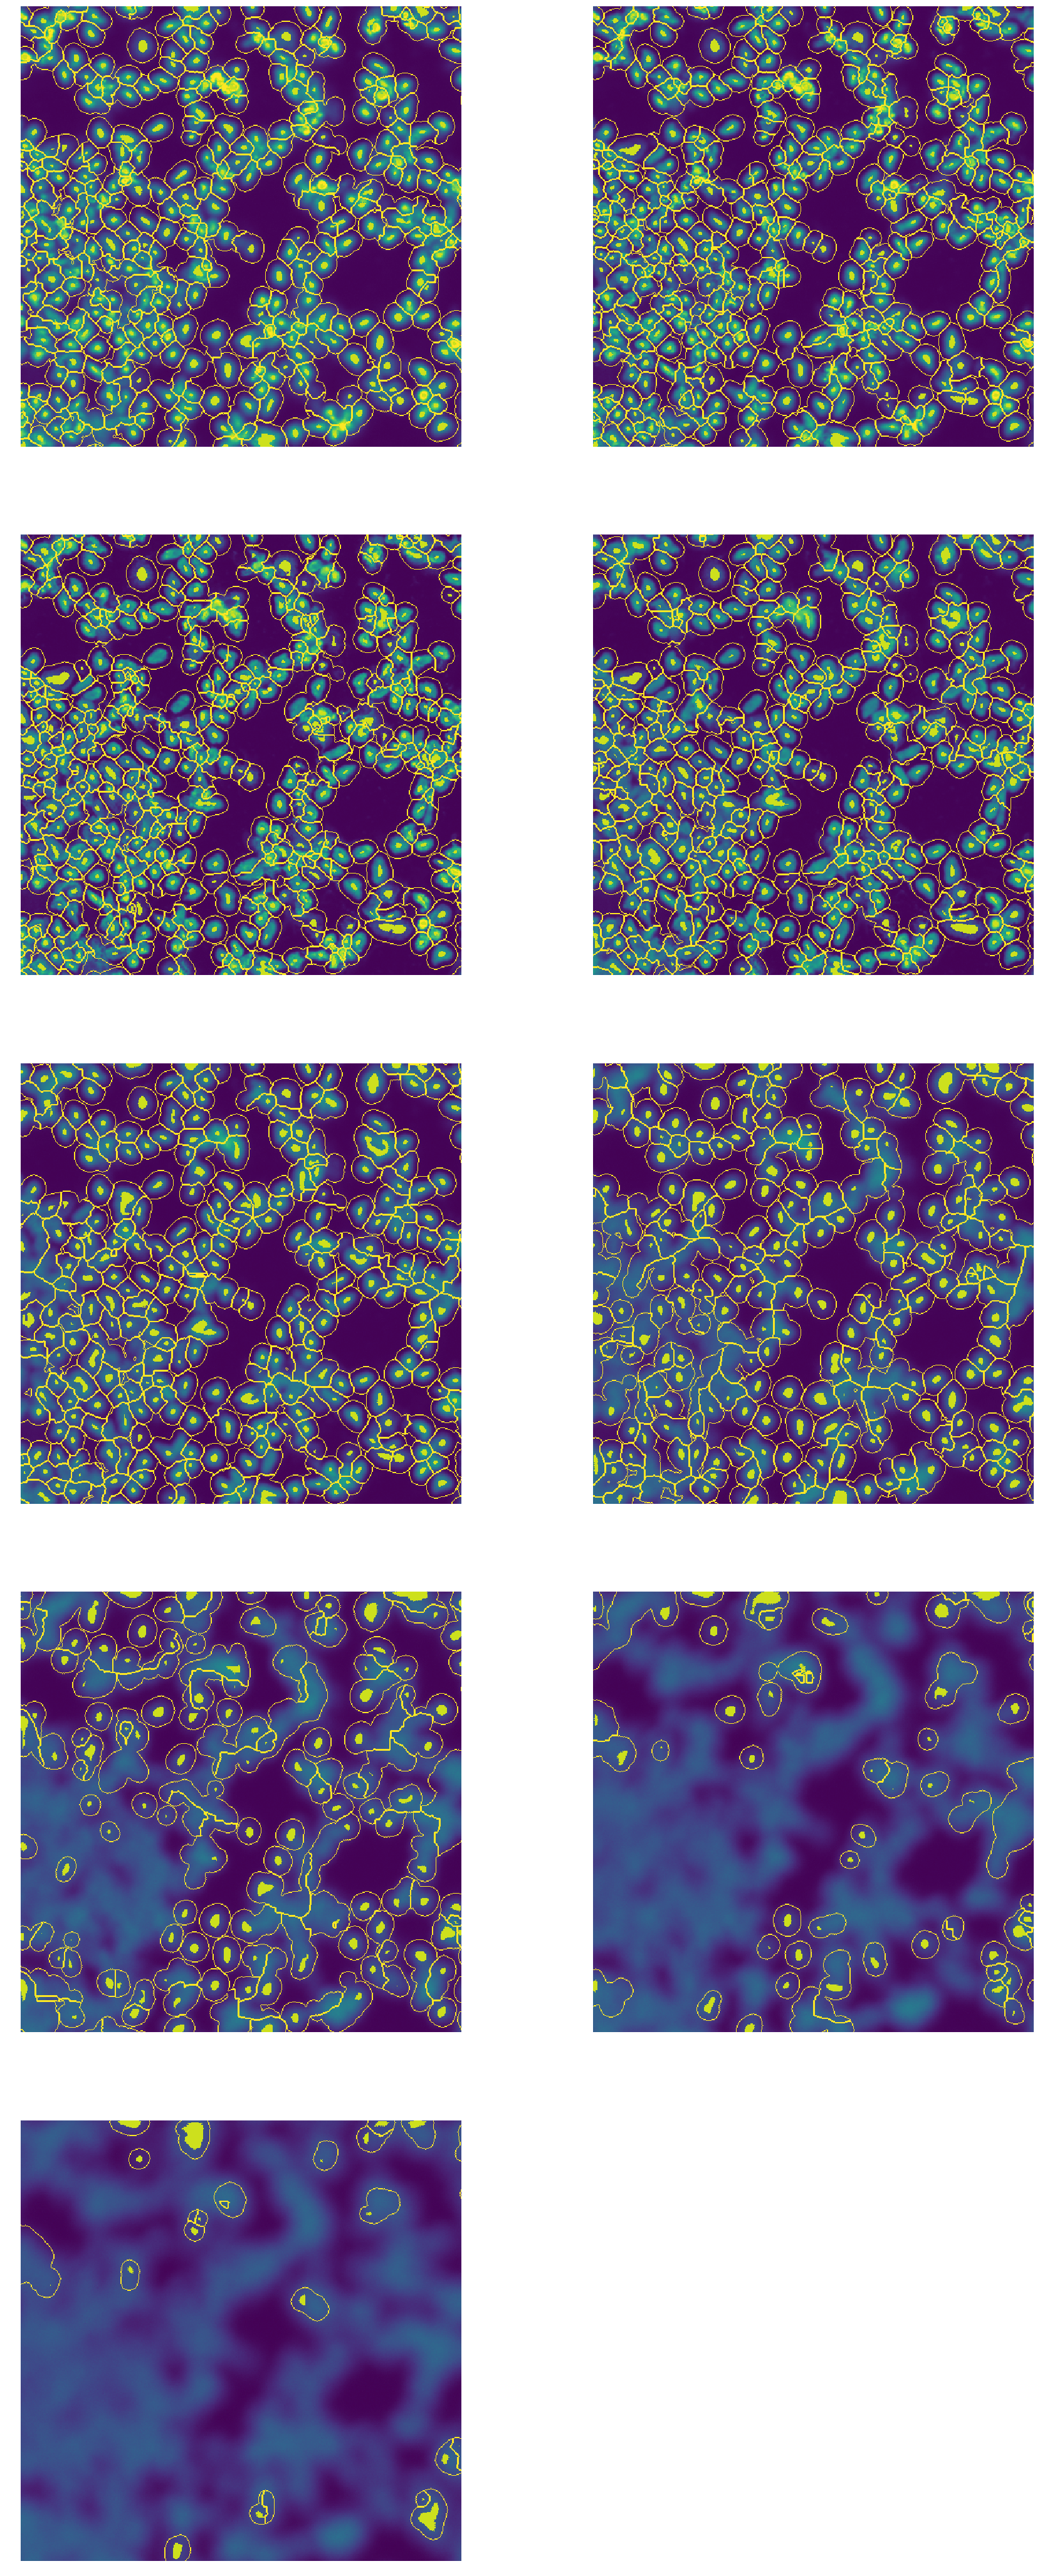

In [95]:
crop = [slice(0, 512), slice(0, 512)]
visualize.display_images([
    img_nuc_border[i][crop]
    #img_pred[i][crop].astype(float) 
    for i in range(img_nuc_border.shape[0])
], size=30, cols=2, cmap='viridis')

In [72]:
tile.shape

(8, 9, 4, 1008, 1344)

In [73]:
%%time
def quantify(tile, cell_segmentation, channel_names=None, channel_name_prefix='ch:'):
    ncyc, nz, _, nh, nw = tile.shape
    
    tile = np.moveaxis(tile, 0, -1)
    tile = np.moveaxis(tile, 1, -1)
    print(tile.shape)
    tile = np.reshape(tile, (nz, nh, nw, -1))
    nch = tile.shape[-1]
    
    if channel_names is None:
        channel_names = ['{}{:03d}'.format(channel_name_prefix, i) for i in range(nch)]
    else:
        channel_names = [channel_name_prefix + c for c in channel_names]
    if nch != len(channel_names):
        raise ValueError(
            'Data tile contains {} channels but channel names list contains only {} items '
            '(names given = {}, tile shape = {})'
            .format(nch, len(channel_names), channel_names, tile.shape))
    
    res = []
    for iz in range(nz):
        props = measure.regionprops(cell_segmentation[iz])
        for i, prop in enumerate(props):
            # Get a (n_pixels, n_channels) array of intensitiy values associated with
            # this region and then average across n_pixels dimension 
            intensities = tile[iz][prop.coords[:,0], prop.coords[:,1]].mean(axis=0)
            assert intensities.ndim == 1
            assert len(intensities) == nch
            row = [i, prop.centroid[1], prop.centroid[0], iz, prop.area]
            row += list(intensities)
            res.append(row)
            
    return pd.DataFrame(res, columns=['id', 'x', 'y', 'z', 'area'] + channel_names)
            
        
df = quantify(tile, img_seg, channel_names=exp_conf.channel_names)

(9, 1008, 1344, 8, 4)
CPU times: user 3.52 s, sys: 235 ms, total: 3.76 s
Wall time: 3.75 s


In [74]:
df[df['z']==0].head()

id           x         y  z  area  ch:HOECHST1  ch:CollagenIV     ch:CD7  \
0   0  121.265625  5.246094  0   256    98.011719       6.371094  16.226562   
1   1  140.099656  6.773196  0   291    60.876289       5.810997   9.560137   
2   2  196.817814  5.734818  0   494    96.457490       7.291498  20.641700   
3   3  269.057927  5.652439  0   328    44.716463       3.469512   6.576220   
4   4  333.234589  9.890411  0   584    56.750000       3.803082   7.073630   

    ch:Ki67  ch:HOECHST2    ...      ch:CD22  ch:CD279  ch:HOECST7    ch:CD8  \
0  3.003906   220.343750    ...     8.105469  2.058594  247.375000  9.664062   
1  2.371134   188.240550    ...     6.254296  1.920962  199.161512  6.364261   
2  3.801619   223.702429    ...     9.591093  2.080972  241.840081  8.921053   
3  2.911585   149.091463    ...     4.176829  1.640244  171.405488  4.524390   
4  1.765411   160.265411    ...     4.592466  1.652397  185.941781  4.815068   

     ch:CD40  ch:cytokeratin  ch:HOECHST8    ch:CD9  ch:Podoplanin  ch:CD11c  
0   8.089844        1.777344   255.000000  8.414062       7.835938  1.757812  
1   5.896907        1.707904   249.532646  6.161512       5.518900  1.570447  
2  15.777328        1.858300   255.000000  9.655870       7.542510  1.740891  
3   3.792683        1.408537   248.426829  4.792683       4.000000  1.481707  
4   4.445205        1.398973   254.688356  7.340753       4.400685  1.585616  

[5 rows x 37 columns]

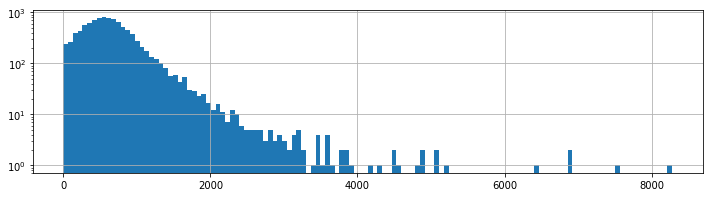

In [75]:
ax = df['area'].hist(bins=128, figsize=(12,3))
ax.set_yscale('log')

In [76]:
dfp = df[df['area'].between(100, 1000)].copy()

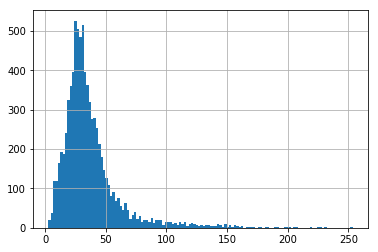

In [77]:
dfp['ch:CD3'].hist(bins=128)
None

In [78]:
dfp = dfp[dfp['ch:CD3'].between(30, 50)]

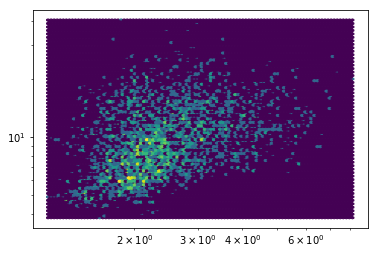

In [79]:
plt.hexbin(
    dfp['ch:CD4'].clip_lower(.1), 
    dfp['ch:CD8'].clip_lower(.1), 
    bins='log', xscale='log', yscale='log', cmap='viridis')